## Overview

This Jupyter notebook focuses on training a machine learning model to predict house prices. We utilize preprocessed data from the "House_Sales_Preprocessing.ipynb" notebook. The dataset used in this analysis contains real estate listings in the US broken by State and zip code, downloaded from https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error , mean_absolute_error , r2_score

In [3]:
df = pd.read_csv('Preprocessed_Data.csv')
df.sample(10)

,status,bed,bath,acre_lot,city,state,zip_code,house_size,price
41349,for_sale,5.0,3.0,1.13,Monroe,New Jersey,8831.0,1200.0,13.794288
15324,for_sale,3.0,2.0,0.40,Laconia,New Hampshire,3246.0,1066.0,12.834684
32601,for_sale,3.0,3.0,0.11,West Orange,New Jersey,7052.0,1200.0,13.479899
17858,for_sale,3.0,2.0,0.67,Chittenden,Vermont,5737.0,1456.0,12.574185
3072,for_sale,3.0,2.0,0.99,Ware,Massachusetts,1082.0,1200.0,11.154835
12503,for_sale,4.0,3.0,0.16,Hyannis,Massachusetts,2601.0,1934.0,13.296318
32511,for_sale,1.0,1.0,0.14,Hillside,New Jersey,7205.0,1200.0,12.574185
21819,for_sale,4.0,3.0,0.56,Orange,Connecticut,6477.0,2112.0,13.217494
53914,for_sale,4.0,3.0,0.11,Beach Haven,New Jersey,8008.0,2106.0,14.284890
34727,for_sale,3.0,1.0,0.11,New York City,New York,10003.0,1200.0,13.303019


In [4]:
df.describe(include='all')

,status,bed,bath,acre_lot,city,state,zip_code,house_size,price
count,70708,70708.000000,70708.000000,70708.000000,70708,70708,70708.000000,70708.000000,70708.000000
unique,2,NaN,NaN,NaN,2033,11,NaN,NaN,NaN
top,for_sale,NaN,NaN,NaN,New York City,New Jersey,NaN,NaN,NaN
freq,70531,NaN,NaN,NaN,5335,25593,NaN,NaN,NaN
mean,NaN,2.872122,2.076385,0.227906,NaN,NaN,7404.475816,1441.236536,13.018682
std,NaN,1.124706,0.856371,0.242642,NaN,NaN,3013.937266,563.494039,0.828787
min,NaN,1.000000,1.000000,0.000000,NaN,NaN,601.000000,104.000000,10.689123
25%,NaN,2.000000,1.000000,0.110000,NaN,NaN,6249.000000,1200.000000,12.506181
50%,NaN,3.000000,2.000000,0.110000,NaN,NaN,7960.000000,1200.000000,13.014780
75%,NaN,3.000000,3.000000,0.240000,NaN,NaN,10019.000000,1700.000000,13.526496


In [19]:
# Apply one-hot encoding
df = pd.get_dummies(df, columns=['status'])
df = pd.get_dummies(df, columns=['city'])
df = pd.get_dummies(df, columns=['state'])

#Features and Target variable
X = df.drop(['price'], axis=1)
y = df['price']
print(f"X shape: {X.shape}, y shape: {y.shape}")

#Splitting the Dataset for Training and Testing 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

X shape: (70046, 2051), y shape: (70046,)
x_train shape: (56036, 2051), y_train shape: (56036,)
x_test shape: (14010, 2051), y_test shape: (14010,)


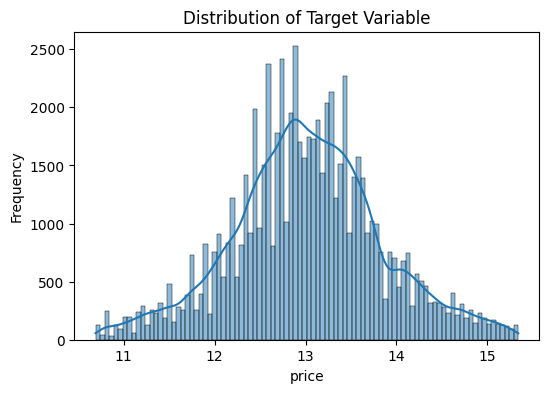

In [7]:
#Distribution of the target variable
plt.figure(figsize=(6, 4))
sns.histplot(df['price'], kde=True)
plt.title(f'Distribution of Target Variable')
plt.xlabel('price')
plt.ylabel('Frequency')
plt.show()

### Model Training

In [9]:
model = {
    'RF'  : RandomForestRegressor(),
    'XGB' : XGBRegressor()
}

params = {
    'RF' : {
         'n_estimators': [100, 200],
         'max_depth' : [None, 10 ,20],
         'min_samples_leaf': [1,2],
         'min_samples_split': [2,5,10]
    },
    'XGB' : {
        'n_estimators': [100, 200],
        'max_depth': [3, 5 , 7],
        'learning_rate' : [0.01 , 0.1, 0.5],
        'gamma' : [0.01, 0.1, 0.5]
    }
}

In [10]:
def calc_metric(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return (mse, rmse, mae, r2)

In [11]:
def find_best_model(models, params, x_train, y_train, x_test, y_test):
    model_performance = []
    fitted_models = {}

    for model_name, model in models.items():
        param_grid = params[model_name]
        gs = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
        gs.fit(x_train, y_train)
        y_pred = gs.predict(x_test)
        
        mse, rmse, mae, r2 = calc_metric(y_test, y_pred)
        
        model_performance.append({
            'model': model_name,
            'best_params': gs.best_params_,
            'best_score': gs.best_score_,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2
        })

        fitted_models[model_name] = gs.best_estimator_
    
    col_name = ['model', 'best_params', 'best_score', 'MSE', 'RMSE', 'MAE', 'R²']
    return pd.DataFrame(model_performance, columns=col_name), fitted_models

In [12]:
df_models, fitted_models = find_best_model(model, params, x_train, y_train, x_test, y_test)
df_models

/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,model,best_params,best_score,MSE,RMSE,MAE,R²
0,RF,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.790245,0.141400,0.376032,0.257984,0.795705
1,XGB,"{'gamma': 0.1, 'learning_rate': 0.5, 'max_dept...",0.781285,0.149974,0.387265,0.276171,0.783317


In [13]:
model_v1 = fitted_models['RF']  
model_v2 = fitted_models['XGB'] 

### Random Forest Model

In [14]:
y_train_pred = model_v1.predict(x_train)
(mse, rmse, mae, r2) = calc_metric(y_train, y_train_pred)
print('Training set metrics:')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')
print('\n')

y_test_pred = model_v1.predict(x_test)
(mse, rmse, mae, r2) = calc_metric(y_test, y_test_pred)
print('Testing set metrics:')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Training set metrics:
Mean Squared Error: 0.05577246919811866
Root Mean Squared Error: 0.23616195544185067
Mean Absolute Error: 0.16239496479506235
R-squared: 0.9188966434996588


Testing set metrics:
Mean Squared Error: 0.14140014661748754
Root Mean Squared Error: 0.37603210849272906
Mean Absolute Error: 0.2579836493349134
R-squared: 0.7957048910246038


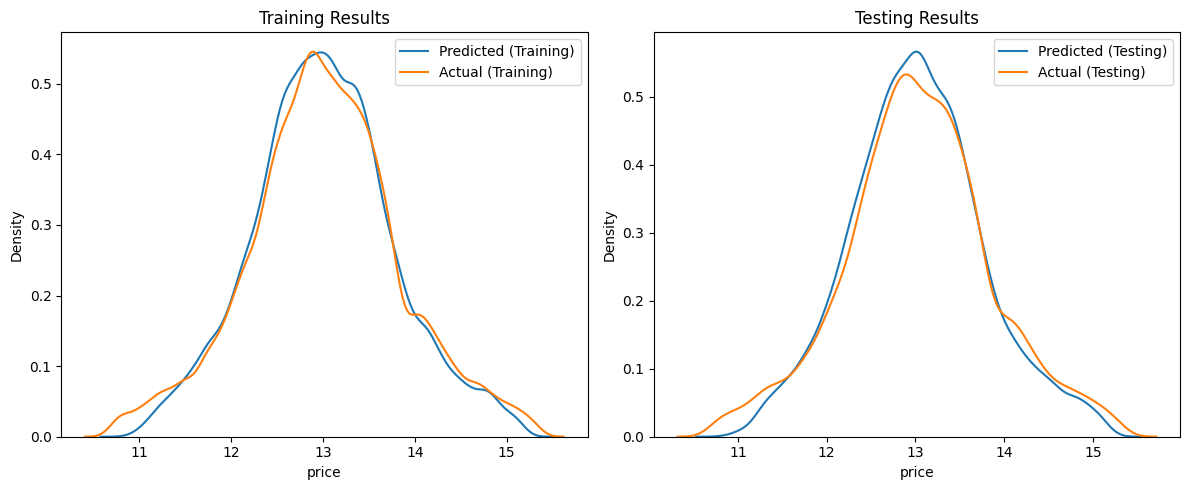

In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.kdeplot(data=y_train_pred, label="Predicted (Training)")
sns.kdeplot(data=y_train, label="Actual (Training)")
plt.title("Training Results")
plt.legend()

plt.subplot(1, 2, 2)
sns.kdeplot(data=y_test_pred, label="Predicted (Testing)")
sns.kdeplot(data=y_test, label="Actual (Testing)")
plt.title("Testing Results")
plt.legend()

plt.tight_layout()
plt.show()

### Extreme Gradient Boosting Model

In [16]:
y_train_pred = model_v2.predict(x_train)
(mse, rmse, mae, r2) = calc_metric(y_train, y_train_pred)
print('Training set metrics:')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')
print('\n')

y_test_pred = model_v2.predict(x_test)
(mse, rmse, mae, r2) = calc_metric(y_test, y_test_pred)
print('Testing set metrics:')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Training set metrics:
Mean Squared Error: 0.10742163691359939
Root Mean Squared Error: 0.3277524018426095
Mean Absolute Error: 0.23610311862550612
R-squared: 0.8437893204350411


Testing set metrics:
Mean Squared Error: 0.14997431963787478
Root Mean Squared Error: 0.38726517999669785
Mean Absolute Error: 0.27617143895864055
R-squared: 0.7833169151032459


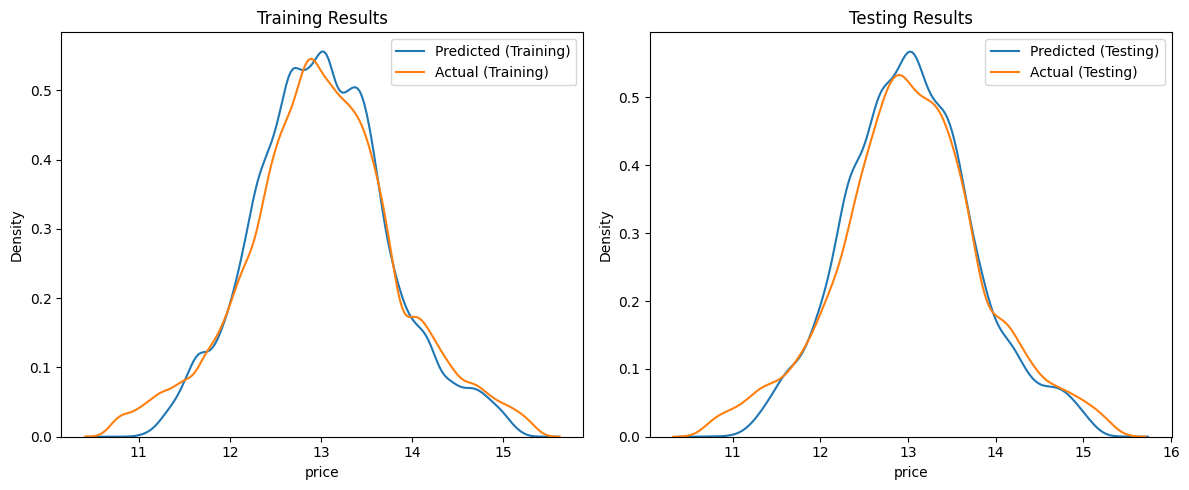

In [17]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.kdeplot(data=y_train_pred, label="Predicted (Training)")
sns.kdeplot(data=y_train, label="Actual (Training)")
plt.title("Training Results")
plt.legend()

plt.subplot(1, 2, 2)
sns.kdeplot(data=y_test_pred, label="Predicted (Testing)")
sns.kdeplot(data=y_test, label="Actual (Testing)")
plt.title("Testing Results")
plt.legend()

plt.tight_layout()
plt.show()

#### Saving ML models and artifacts for deployment

In [7]:
#Save Columns Names as JSON
data_columns = [col for col in X.columns]

import json
columns = {'data_columns' : data_columns}
with open ('data_columns.json' , 'w') as f:
    json.dump(columns , f)

In [4]:
#Group Cities by State and Save as JSON
state_city_dict = df.groupby('state')['city'].apply(lambda x: list(set(x))).to_dict()

import json
with open('state_city.json', 'w') as json_file:
    json.dump(state_city_dict, json_file)

In [20]:
#Save ML Models
import pickle
with open('ml_model_v1.pickle' , 'wb') as f:
    pickle.dump(model_v1 , f)
with open('ml_model_v2.pickle' , 'wb') as f:
    pickle.dump(model_v2 , f) 